# Algorithmic Development for Reconstructing Air-Sea Exchange

In this notebook, we reproduce the evaluation of reconstruction skills of a machine learning algorithm using one Earth system model, a small example motivated by Gloege et al (2021). 

This notebook provides a set of starter codes for [LEAP CPC Spring 2022](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges)[Project 3](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges/tree/main/Project-StarterCodes/Project3-PredModel) on

+ how to load data from an Earth system model,
+ how to set up a machine learning for creating reconstruction based on observed data,
+ how to evaluate and visualize the reconstruction.

All the codes in this notebook can be modified to implement research ideas. 

To start, the **team leader** of each team should 
+ create in the course folder a folder for **project 3**.
This folder can be used to share notes, data, outputs and codes. 

+ share project 3 folder with all team members.
+ team members should add this folder to their drive by creating a shortcut to this shared project folder in their own folder for LEAP CPC.
+ go to "File/Save A Copy in Drive/" (upper left) and save a copy for your team in the project 2 folder that was just created, under an appropriate subfolder. 
+ for collaboration, team members should all add a shortcut of their project 2 folder to the folder "Colab Notebooks" in the root of your Google Drive. See below for more instructions. 

## Part I: Install python packages and set up workplace


### Step I.1: Install packages

In [2]:
# install the packages from website
!pip install SkillMetrics
!pip install cmocean
!pip3 install cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely

  Using cached Cartopy-0.20.2.tar.gz (10.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  Using cached Cartopy-0.20.1.tar.gz (10.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  Using cached Cartopy-0.20.0.tar.gz (10.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  Using cached Cartopy-0.19.0.post1.tar.gz (12.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 44 kB 1.6 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516282 sha256=f5109a800ce3f440d0fede1a497053fe082249de545b3aa92f99ca106d683710
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
Successfully built cartopy
Found existing installation: Shapely 1.8.1.post1
U

### Step I.2 Import necessary packages

In [1]:
# import necessary packages
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import joblib
import pickle
import skill_metrics as sm

import seaborn as sns
import cmocean as cm            # really nice colorbars
import matplotlib.pyplot as plt # for making plots

# machine learning libraries
from sklearn.model_selection import train_test_split


In [2]:
# step 1 connect colab to google drive
from google.colab import drive
drive.mount('/content/drive')
root_dir = "/content/drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 3/" # change it to your own project dir

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step I.3: Here is to set the work directory 

In [3]:
os.chdir(f"{root_dir}/lib/") 
print(os.getcwd())
#/content/drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 3/lib/

/content/drive/.shortcut-targets-by-id/10Z7AEDZRHDhykMqJePGeu8gnJ8BXvcFy/LEAP Colab Notebooks/Project 3/lib


### Step I.4: Load user python codes that contain user-created functions.

In [4]:
# Python file with supporting functions
import pre 
#import decompose as stl
from spatial_map import SpatialMap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Part II: Reconstruction
In this part, ...

### Step II.1 Define reconstruction experiment parameters.

In [6]:
# define ens, member, time, and some dir of files
ens = 'CanESM2'
member = 'r1r10'

date_range_start = '1982-01-01T00:00:00.000000000'
date_range_end = '2017-01-31T00:00:00.000000000'

dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

data_output_dir = f"{root_dir}/data/processed"
ensemble_dir_head = f"{root_dir}/models/CanESM2r1r10" # Set this to where you have placed the raw data
xco2_path = f"{root_dir}/models/CESM001/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc" # Forcing is the same across members so only reference it once


reference_output_dir = f"{root_dir}/references"
model_output_dir = f"{root_dir}/models/trained"
recon_output_dir = f"{root_dir}/models/reconstructions"
other_output_dir = f"{root_dir}/models/performance_metrics"

approach = "xg"
approach_output_dir = f"{other_output_dir}/{approach}"
param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"


### Step II.2 Load member data

In [8]:
# load and save data
df = pre.create_inputs(ensemble_dir_head, ens, member, dates, xco2_path=xco2_path)
pre.save_clean_data(df, data_output_dir, ens, member)

# the data preprocess take 60 s

start to import member data
finish importing member data
start to create feature
Starting data saving process
Save complete


### Step II.3 start to train model.

In [9]:
# machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
import xgboost as xgb     # extreme gradient boosting (XGB
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# =========================================
# Defining some inputs for the modeling process
# =========================================

# Train-validate-test split proportions
val_prop = .2
test_prop = .2

# Parameter grids
xg_param_grid = {"n_estimators":[2000, 3000, 4000],
                 "max_depth":[4,5,6]
                }

# Feature and target lists for feeding into the models
features_sel = ['sst_detrend', 'sst_anom', 'sss', 'sss_anom', 'mld_clim_log', 'chl_log', 'chl_anom', 'xco2', 'A', 'B', 'C', 'T0', 'T1']
target_sel = ['pCO2']

## Part III: Evaluating reconstruction

### Step III.1 prepare seen and unseen data.

In [10]:
# it takes 39 seconds
# data preparation. prepare the seen and unseen data. split the trian and test data


data_dir = f"{data_output_dir}/{ens}/member_{member}"
fname = f"data_clean_2D_mon_{ens}_{member}_1x1_198201-201701.pkl"
file_path = f"{data_dir}/{fname}"
        
# Read in data, create some selection filters, produce a reduced dataframe
df = pd.read_pickle(file_path)

# 816 represents 3 standard deviations above mean in SOCAT data -- observations above this threshold are unrealistic to observe in real-world data
recon_sel = (~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)) & (df[target_sel] < 816).to_numpy().ravel()
sel = (recon_sel & (df['socat_mask'] == 1))
unseen_sel = (recon_sel & (df['socat_mask'] == 0))
        
 # Convert dataframe to numpy arrays, train/val/test split
X = df.loc[sel,features_sel].to_numpy()
y = df.loc[sel,target_sel].to_numpy().ravel()
                
N = X.shape[0]
train_val_idx, train_idx, val_idx, test_idx = pre.train_val_test_split(N, test_prop, val_prop)
X_train_val, X_train, X_val, X_test, y_train_val, y_train, y_val, y_test = pre.apply_splits(X, y, train_val_idx, train_idx, val_idx, test_idx) 
        
# Define the model based on which approach to use    
# if first_mem:
#   model = XGBRegressor(n_jobs=jobs)
#   param_grid = xg_param_grid
#   grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=K_folds, return_train_score=False, refit=False)
#   grid.fit(X_train_val, y_train_val)
#   best_params[ens] = grid.best_params_
#   first_mem = False


In [11]:
# Fit the model on train/validation data
# it take 17 seconds to train the model
model = XGBRegressor(n_jobs=1)
model.fit(X_train_val, y_train_val)          

# Save the model
pre.save_model(model, model_output_dir, approach, ens, member)

[03:59:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Starting model saving process
Save complete


In [12]:
# Calculate some test error metrics and store in a dictionary
test_performance = defaultdict(dict)

y_pred_test = model.predict(X_test)
test_performance[ens][member] = pre.evaluate_test(y_test, y_pred_test)

In [13]:
# Redo this analysis on the unseen data

unseen_performance = defaultdict(dict)
y_pred_unseen = model.predict(df.loc[unseen_sel,features_sel].to_numpy())
y_unseen = df.loc[unseen_sel,target_sel].to_numpy().ravel()
unseen_performance[ens][member] = pre.evaluate_test(y_unseen, y_pred_unseen)

In [14]:
y_pred_seen = model.predict(X)
df['pCO2_recon'] = np.nan
df.loc[unseen_sel,['pCO2_recon']] = y_pred_unseen
df.loc[sel,['pCO2_recon']] = y_pred_seen
DS_recon = df[['net_mask','socat_mask','pCO2', 'pCO2_recon']].to_xarray()
pre.save_recon(DS_recon, recon_output_dir, approach, ens, member)

Starting reconstruction saving process
Save complete


In [15]:
# Convert performance metrics to dataframes
test_df = pd.DataFrame.from_dict({(i,j): test_performance[i][j]
                                  for i in test_performance.keys()
                                  for j in test_performance[i].keys()},
                                 orient='index')

unseen_df = pd.DataFrame.from_dict({(i,j): unseen_performance[i][j]
                                  for i in unseen_performance.keys()
                                  for j in unseen_performance[i].keys()},
                                 orient='index')

test_df.index.names = ["model","member"]
unseen_df.index.names = ["model","member"]

# Save the dataframes too
test_df_fname = f"{approach_output_dir}/{approach}_test_performance_df.pickle"
unseen_df_fname = f"{approach_output_dir}/{approach}_unseen_performance_df.pickle"

test_df.to_pickle(test_df_fname)
unseen_df.to_pickle(unseen_df_fname)

In [7]:
# remember to change recon_output_dir to your own directory
# take 47 senconds
pre.apply_detrend('xg', ens, member)

/content/drive/.shortcut-targets-by-id/10Z7AEDZRHDhykMqJePGeu8gnJ8BXvcFy/LEAP Colab Notebooks/Project 3/lib


In [8]:
#Full reconstruction and temporal deconstruction metric maps
# it take 20 seconds

data_types = ["raw", "seasonal", "deseason"]

map_data = defaultdict(float) # Data by ML approach
map_data_ens = defaultdict(float) # Data by ML approach and ensemble model

N_ens = 1
N_tot = 1

recon_dir = f"{recon_output_dir}/{approach}/{ens}/member_{member}"
            
recon_fname_out = f"{recon_dir}/{approach}_recon_temporal_pC02_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
            
DS_recon = xr.load_dataset(recon_fname_out)
                        
recon = {}
recon["raw"] = DS_recon["pCO2_recon"]
for i in data_types[1:]:
  recon[i] = DS_recon[f"pCO2_recon_{i}"]

ref = {}
ref["raw"] = DS_recon["pCO2"]
for i in data_types[1:]:
  ref[i] = DS_recon[f"pCO2_{i}"]
                
for i in data_types:
  xmean = ref[i].mean("time")
  ymean = recon[i].mean("time")
  x_minus_mean = ref[i] - xmean
  y_minus_mean = recon[i] - ymean
  ssx = xr.ufuncs.sqrt((x_minus_mean**2).sum("time"))
  ssy = xr.ufuncs.sqrt((y_minus_mean**2).sum("time"))
                
  corr = ( x_minus_mean * y_minus_mean ).sum("time") / (ssx*ssy)
  std_x = ref[i].std("time")
  std_y = recon[i].std("time")
  bias = (ymean - xmean)
                
                # Average bias
  map_data[(approach,i,"bias_mean")] += bias / N_tot
  map_data_ens[(ens,approach,i,"bias_mean")] += bias / N_ens
                
                # Average bias**2
  map_data[(approach,i,"bias_sq")] += bias**2 / N_tot
  map_data_ens[(ens,approach,i,"bias_sq")] += bias**2 / N_ens
                
                # Max bias
  map_data[(approach,i,"bias_max")] = np.maximum(map_data[(approach,i,"bias_max")], bias)
  map_data_ens[(ens,approach,i,"bias_max")] = np.maximum(map_data_ens[(ens,approach,i,"bias_max")], bias)
                
                # Min bias
  map_data[(approach,i,"bias_min")] = np.minimum(map_data[(approach,i,"bias_min")], bias)
  map_data_ens[(ens,approach,i,"bias_min")] = np.minimum(map_data_ens[(ens,approach,i,"bias_min")], bias)
                
                # Mean absolute error
  map_data[(approach,i,"mae")] += np.abs(bias) / N_tot
  map_data_ens[(ens,approach,i,"mae")] += np.abs(bias) / N_ens
                
                # Mean % bias
  map_data[(approach,i,"bias_%error")] += bias/xmean / N_tot
  map_data_ens[(ens,approach,i,"bias_%error")] += bias/xmean / N_ens
                
                # Mean absolute % bias
  map_data[(approach,i,"mae_%error")] += np.abs(bias)/xmean / N_tot
  map_data_ens[(ens,approach,i,"mae_%error")] += np.abs(bias)/xmean / N_ens
                
                # Mean correlation
  map_data[(approach,i,"corr_mean")] += corr / N_tot
  map_data_ens[(ens,approach,i,"corr_mean")] += corr / N_ens
                
                # Average corr**2
  map_data[(approach,i,"corr_sq")] += corr**2 / N_tot
  map_data_ens[(ens,approach,i,"corr_sq")] += corr**2 / N_ens

                # Stdev (amplitude) percentage error
  map_data[(approach,i,"amp_%error")] += (std_y-std_x)/std_x / N_tot
  map_data_ens[(ens,approach,i,"amp_%error")] += (std_y-std_x)/std_x / N_ens

                # Stdev (amplitude) absolute percentage error           
  map_data[(approach,i,"stdev_%error")] += np.abs(std_y-std_x)/std_x / N_tot
  map_data_ens[(ens,approach,i,"stdev_%error")] += np.abs(std_y-std_x)/std_x / N_ens


for i in data_types:
  map_data[(approach,i,"bias_std")] = np.sqrt(map_data[(approach,i,"bias_sq")] - map_data[(approach,i,"bias_mean")]**2)
  map_data[(approach,i,"corr_std")] = np.sqrt(map_data[(approach,i,"corr_sq")] - map_data[(approach,i,"corr_mean")]**2)

  map_data_ens[(ens,approach,i,"bias_std")] = np.sqrt(map_data_ens[(ens,approach,i,"bias_sq")] - map_data_ens[(ens,approach,i,"bias_mean")]**2)
  map_data_ens[(ens,approach,i,"corr_std")] = np.sqrt(map_data_ens[(ens,approach,i,"corr_sq")] - map_data_ens[(ens,approach,i,"corr_mean")]**2)


In [9]:
map_data_fname = f"{other_output_dir}/map_data_approach.pickle"
map_data_ens_fname = f"{other_output_dir}/map_data_ens.pickle"

with open(map_data_fname,"wb") as handle:
  pickle.dump(map_data, handle)

with open(map_data_ens_fname,"wb") as handle:
  pickle.dump(map_data_ens, handle)

In [10]:
# Pulling in map metrics
other_output_dir = f"{root_dir}/models/performance_metrics"


map_data_fname = f"{other_output_dir}/map_data_approach.pickle"
map_data_ens_fname = f"{other_output_dir}/map_data_ens.pickle"

with open(map_data_fname,"rb") as handle:
  map_data = pickle.load(handle)

with open(map_data_ens_fname,"rb") as handle:
  map_data_ens = pickle.load(handle)

bias_mean for raw data by ML approach


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

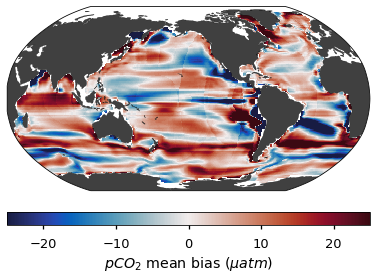

In [11]:
data_sel = "raw"
metric_sel = "bias_mean"
vrange = [-25, 25, 5]
fig_shape = (1,1)
cmap = cm.cm.balance
lab = '$pCO_2$ mean bias ($\mu atm$)'

print(f"{metric_sel} for {data_sel} data by ML approach")      
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(6.5,9))

    ### Mask
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    #for i in range(fig_shape[0]*fig_shape[1]):
    map_sel = map_data[(approach,data_sel,metric_sel)].roll(xlon=-30,roll_coords=True)
    sub = dia.add_plot(lat = map_sel['ylat'],
                      
                       lon = map_sel['xlon'], 
                       data = map_sel.T, 
                       vrange=vrange[0:2], 
                       cmap=cmap,
                       ax = 0)
#         dia.set_title(approaches_labs[i], i, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab);


corr_mean for ['seasonal'] data by ML approach


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

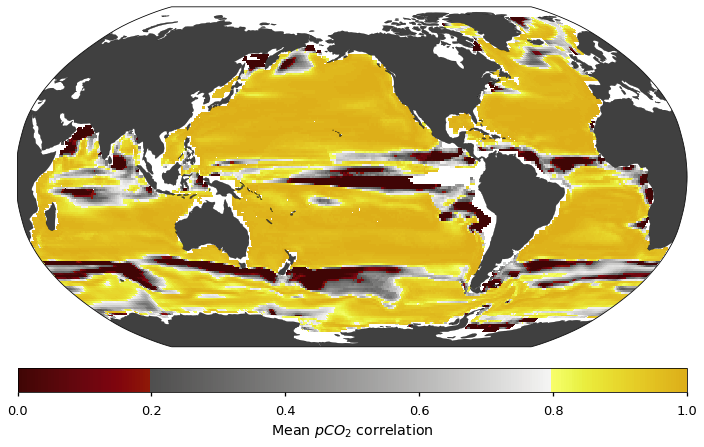

In [12]:
data_sel = ["seasonal"]
metric_sel = "corr_mean"
vrange = [0, 1, .01]
fig_shape = (1,1)
cmap = cm.cm.oxy
lab = 'Mean $pCO_2$ correlation'

print(f"{metric_sel} for {data_sel} data by ML approach")      
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(12,12))
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    for i in range(fig_shape[0]*fig_shape[1]):
        map_sel = map_data[(approach,data_sel[0],metric_sel)].roll(xlon=-30,roll_coords=True)
        sub = dia.add_plot(lat = map_sel['ylat'], 
                           lon = map_sel['xlon'], 
                           data = map_sel.T, 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=i)
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab)

amp_%error for ['seasonal'] data by ML approach


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

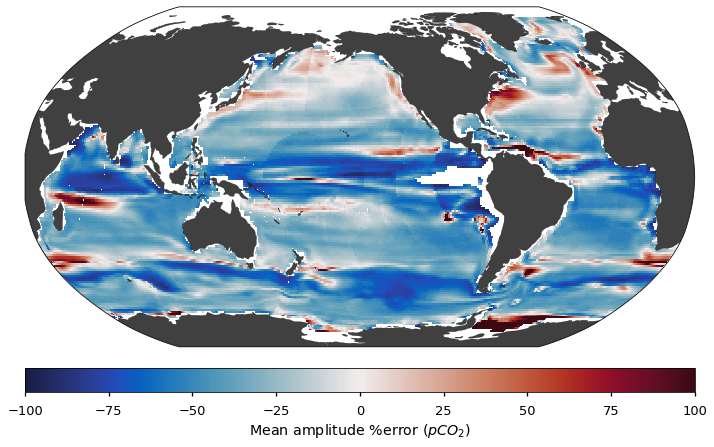

In [13]:
data_sel = ["seasonal"]
metric_sel = "amp_%error"
vrange = [-100, 100, 1]
fig_shape = (1,len(data_sel))
cmap = cm.cm.balance
lab = 'Mean amplitude %error ($pCO_2$)'

print(f"{metric_sel} for {data_sel} data by ML approach")      
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(12,12))
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    

    map_sel = map_data[(approach,data_sel[0],metric_sel)].roll(xlon=-30,roll_coords=True)
    sub = dia.add_plot(lat = map_sel['ylat'], 
                       lon = map_sel['xlon'], 
                       data = map_sel.T*100, 
                       vrange=vrange[0:2], 
                       cmap=cmap, 
                       ax=0)
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab)